In [ ]:
import numpy as np
from scipy.interpolate import interp1d
import json
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import MeanSquaredError
import tensorflow as tf

# 資料讀取

In [ ]:
# 檔案載入
healthy_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PPG/heathdata/s10_sit.csv')
healthy_data = np.array(healthy_data['pleth_3'])

# 繪圖
plt.figure(figsize=(12, 4))
plt.plot(healthy_data, color='blue')
plt.show()

# Non-AF讀取

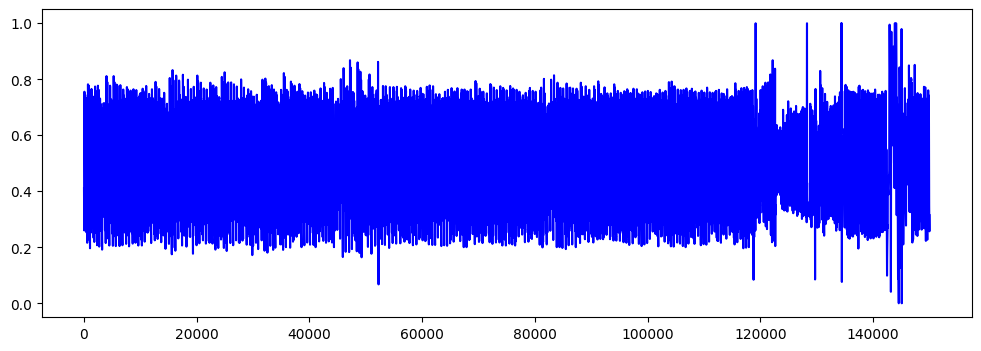

In [ ]:
healthy_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PPG/mimic_perform_non_af_csv/mimic_perform_non_af_001_data.csv')
healthy_ppg_signal = np.array(healthy_data['PPG'])

# 繪圖
plt.figure(figsize=(12, 4))
plt.plot(healthy_ppg_signal, color='blue')
plt.show()

In [ ]:
len(healthy_data)

150001

# 濾波

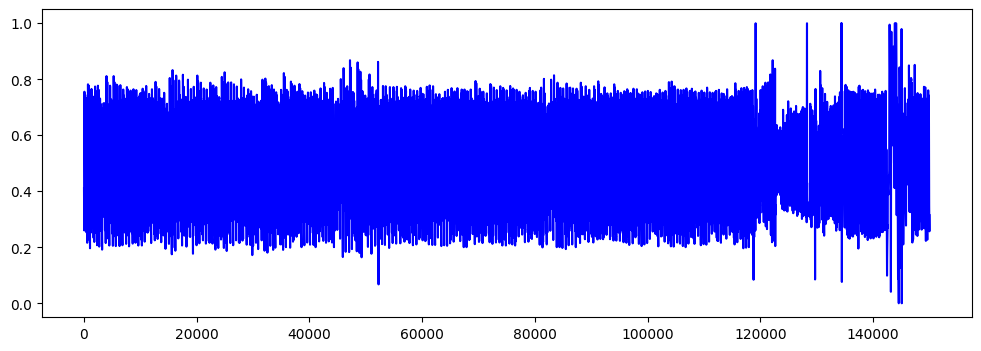

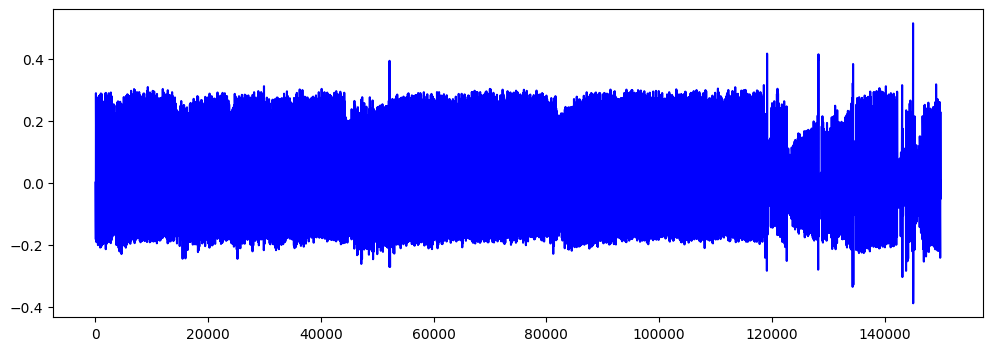

In [ ]:
# 濾波
fs = 125 # 樣本率(Hz)
lowcut = 0.67 # 通帶低頻(Hz)
highcut = 8.0 # 通帶高頻(Hz)
order = 5 # 濾波器的階數


# 設計巴特沃斯帶通濾波器
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data)
    return y

# 開始濾波
healthy_ppg_signal = butter_bandpass_filter(healthy_data, lowcut, highcut, fs, order=3)


# 繪圖
plt.figure(figsize=(12, 4))
plt.plot(healthy_data, color='blue')
plt.show()


plt.figure(figsize=(12, 4))
plt.plot(healthy_ppg_signal, color='blue')
plt.show()

# 資料集分割和插值

In [ ]:
# 資料集分割
fs = 125  # 採樣率(Hz)
segment_length_seconds = 5  # 預切割秒數
segment_length_points = fs * segment_length_seconds  # 每個段落應包含的數據點數量

healthy_ppg_data_noraml = healthy_ppg_signal.tolist()

# 分割PPG訊號數據
segments_ppg = [healthy_ppg_data_noraml [i: i + segment_length_points] for i in range(0, len(healthy_ppg_data_noraml), segment_length_points)]

print(f'採樣率為{fs}，預分割秒數為{segment_length_seconds}，一段為{segment_length_points}數據點')
print(f'切割{len(segments_ppg)}段')
print(f'最後一段為{len(segments_ppg[-1])}個數據點')

if segments_ppg[-1] != segment_length_points:
    segments_ppg.pop()
    print(f'最後一段不足{segment_length_points}，移除最後一段，剩餘{len(segments_ppg)}段')
    print(f'最後一段數據點為{len(segments_ppg[-1])}')

採樣率為125，預分割秒數為5，一段為625數據點
切割241段
最後一段為1個數據點
最後一段不足625，移除最後一段，剩餘240段
最後一段數據點為625


In [ ]:
# 插值
# 因訓練集所採用的採樣率為1000Hz，與目前的資料集不同，需進行插值才能進行predict
def interpolate_signal(original_signal, target_num_points):
    # 原始信号的实际时间长度
    signal_length = len(original_signal)

    # 生成原始信号的时间点
    x_old = np.linspace(0, signal_length, num=signal_length, endpoint=False)

    # 生成目标信号的时间点，确保不超出原始时间范围
    x_new = np.linspace(0, signal_length, num=target_num_points, endpoint=False)

    # 选择插值方法：'linear' 或 'cubic'
    interpolator = interp1d(x_old, original_signal, kind='cubic', bounds_error=False, fill_value="extrapolate")

    # 执行插值
    interpolated_signal = interpolator(x_new)

    return interpolated_signal


# 目标数据点数，例如，将每段信号插值到1000个数据点
target_num_points = 5000

interpolated_ppg_signal = [interpolate_signal(signal, target_num_points) for signal in segments_ppg]

print(f'插值後的第一段資料數據點:{len(interpolated_ppg_signal[0])}，最後一段資料數據點:{len(interpolated_ppg_signal[-1])}')

插值後的第一段資料數據點:5000，最後一段資料數據點:5000


In [ ]:
# MinMax
# 讓每一段資料集各自做MinMax

ppg_signal_noramalized = []
for i in range(len(interpolated_ppg_signal)):
    semgents = np.array(interpolated_ppg_signal[i])
    scaler = MinMaxScaler()
    noramalized = scaler.fit_transform(semgents.reshape(-1, 1)).flatten()
    ppg_signal_noramalized.append(noramalized)

In [ ]:
# 使用 np.expand_dims 增加一個批次維度
predict_input_signal = np.expand_dims(ppg_signal_noramalized, axis=0)
predict_input_signal[0].shape

(240, 5000)

In [ ]:
# non-af專用interpolated_ppg_signal
# 使用 np.expand_dims 增加一個批次維度
predict_input_signal = np.expand_dims(, axis=0)

# 訓練好的模型載入及預測

In [ ]:
# 加載模型
loaded_autoencoder = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/AEmodel/autoencoder_model')

## 預測

In [ ]:
# 預測
predict_value = loaded_autoencoder.predict(predict_input_signal[0])


se = (ppg_signal_noramalized[10] - predict_value[10]) ** 2
mse = np.mean(se)
rmse = np.sqrt(mse)

se1 = (ppg_signal_noramalized[40] - predict_value[40]) ** 2
mse1 = np.mean(se1)
rmse1 = np.sqrt(mse1)

se2 = (ppg_signal_noramalized[50] - predict_value[50]) ** 2
mse2 = np.mean(se2)
rmse2 = np.sqrt(mse2)

se3 = (ppg_signal_noramalized[87] - predict_value[87]) ** 2
mse3 = np.mean(se3)
rmse3 = np.sqrt(mse3)

se4 = (ppg_signal_noramalized[93] - predict_value[93]) ** 2
mse4 = np.mean(se4)
rmse4 = np.sqrt(mse4)


print('健康資料')
print('-------------------')
print('mse:', mse)
print('rmse:', rmse)
print('-------------------')
print('mse:', mse1)
print('rmse:', rmse1)
print('-------------------')
print('mse:', mse2)
print('rmse:', rmse2)
print('-------------------')
print('mse:', mse3)
print('rmse:', rmse3)
print('-------------------')
print('mse:', mse4)
print('rmse:', rmse4)

8/8 [==============================] - 1s 100ms/step
健康資料
-------------------
mse: 0.07385661806780736
rmse: 0.27176574115919644
-------------------
mse: 0.07527003796118872
rmse: 0.2743538553787585
-------------------
mse: 0.06265405920923964
rmse: 0.2503079287782144
-------------------
mse: 0.07557004988753886
rmse: 0.27490007254916987
-------------------
mse: 0.07410067550083833
rmse: 0.2722143925306638


In [1]:
result = autoencoder.evaluate(data, data)

result

NameError: name 'autoencoder' is not defined

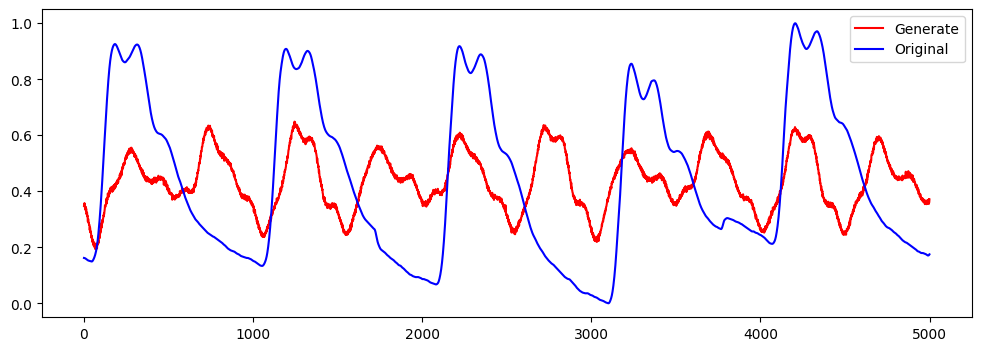

In [ ]:
# 健康
plt.figure(figsize=(12, 4))
plt.plot(predict_value[87], color='r', label='Generate')
# plt.figure(figsize=(12, 4))
plt.plot(ppg_signal_noramalized[87], color='b', label='Original')
plt.legend()
plt.show()

## non-af專用 預測

In [ ]:
# non-af專用
# 預測
predict_value = loaded_autoencoder.predict(predict_input_signal[0])


se = (interpolated_ppg_signal[25] - predict_value[25]) ** 2
mse = np.mean(se)
rmse = np.sqrt(mse)

se1 = (interpolated_ppg_signal[40] - predict_value[40]) ** 2
mse1 = np.mean(se1)
rmse1 = np.sqrt(mse1)

se2 = (interpolated_ppg_signal[200] - predict_value[200]) ** 2
mse2 = np.mean(se2)
rmse2 = np.sqrt(mse2)

se3 = (interpolated_ppg_signal[87] - predict_value[87]) ** 2
mse3 = np.mean(se3)
rmse3 = np.sqrt(mse3)

se4 = (interpolated_ppg_signal[157] - predict_value[157]) ** 2
mse4 = np.mean(se4)
rmse4 = np.sqrt(mse4)


print('健康資料')
print('-------------------')
print('mse:', mse)
print('rmse:', rmse)
print('-------------------')
print('mse:', mse1)
print('rmse:', rmse1)
print('-------------------')
print('mse:', mse2)
print('rmse:', rmse2)
print('-------------------')
print('mse:', mse3)
print('rmse:', rmse3)
print('-------------------')
print('mse:', mse4)
print('rmse:', rmse4)

8/8 [==============================] - 0s 54ms/step
健康資料
-------------------
mse: 0.02736891487994226
rmse: 0.16543553088723795
-------------------
mse: 0.029542808192850083
rmse: 0.17188021466373052
-------------------
mse: 0.011840388062724557
rmse: 0.10881354723895623
-------------------
mse: 0.025194159721903107
rmse: 0.15872668245100793
-------------------
mse: 0.02046772136708542
rmse: 0.14306544435007854


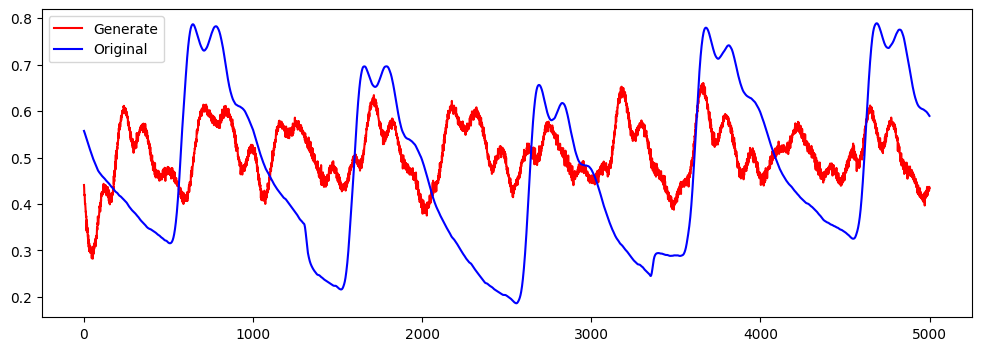

In [ ]:
# 健康
plt.figure(figsize=(12, 4))
plt.plot(predict_value[40], color='r', label='Generate')
# plt.figure(figsize=(12, 4))
plt.plot(interpolated_ppg_signal[40], color='b', label='Original')
plt.legend()
plt.show()